Epoch 1/50
32/32 [==============================] - 5s 50ms/step - loss: 0.6812 - accuracy: 0.6148 - val_loss: 0.6668 - val_accuracy: 0.5714
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.6382 - accuracy: 0.6148 - val_loss: 0.6188 - val_accuracy: 0.5714
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.5863 - accuracy: 0.6148 - val_loss: 0.5770 - val_accuracy: 0.5714
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.5439 - accuracy: 0.6148 - val_loss: 0.5492 - val_accuracy: 0.5714
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.5225 - accuracy: 0.6148 - val_loss: 0.5394 - val_accuracy: 0.5714
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 0.5107 - accuracy: 0.7984 - val_loss: 0.5331 - val_accuracy: 0.8571
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 0.5039 - accuracy: 0.8164 - val_loss: 0.5292 - val_accuracy: 0.8254
Epoch 8/50
32/32 [=

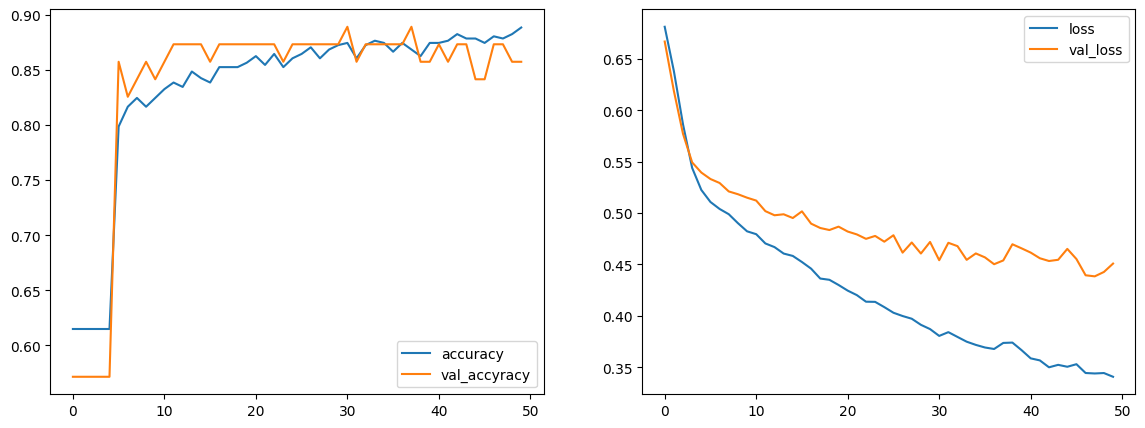

4/4 [==============================] - 0s 11ms/step - loss: 0.6566 - accuracy: 0.6984
Loss : 0.6566153764724731  ; Accuracy : 0.6984127163887024


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

titanic_data = tf.keras.utils.get_file("train.csv",
                                      "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_df = pd.read_csv(titanic_data)
titanic_df.head(5)

titanic_df.rename(columns={"survived":"target"},inplace=True)
np.random.seed(5)

train,val,test = np.split(titanic_df.sample(frac=1),[int(len(titanic_df) * 0.8),int(len(titanic_df) * 0.9)])

def df_to_dataset(dataframe,shuffle=True,batch_size = 32):
    df = dataframe.copy()
    labels = df.pop("target")
    ds = {key : value.values[:,tf.newaxis] for key,value in df.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(ds),labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

batch_size = 16
train_ds = df_to_dataset(train,batch_size=batch_size)
val_ds = df_to_dataset(val,batch_size=batch_size)
test_ds = df_to_dataset(test,batch_size=batch_size)

all_inputs = []
encoded_features = []
numerical_cols = ['age','fare']
numerical_categorical_cols = ['n_siblings_spouses','parch']
categorical_cols = ['sex','class','deck','embark_town','alone']

## Encoding Layers
def get_normalization_layer(name,dataset):
    normalization_layer = tf.keras.layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x,y : x[name])
    normalization_layer.adapt(feature_ds)
    return normalization_layer

def get_encoding_layer(name,dataset,dtype,max_tokens = None):
    if dtype == "string":
        index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
    else:
        index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)
    
    feature_ds = dataset.map(lambda x,y : x[name])
    index.adapt(feature_ds)
    encoding_layer = tf.keras.layers.CategoryEncoding(index.vocabulary_size())
    return lambda feature : encoding_layer(index(feature))

for header in numerical_cols:
    numerical_col = tf.keras.Input(shape=(1,),name=header)
    normalization_layer = get_normalization_layer(header,train_ds)
    encoded_numerical_col = normalization_layer(numerical_col)
    all_inputs.append(numerical_col)
    encoded_features.append(encoded_numerical_col)
    
for header in numerical_categorical_cols:
    numerical_categorical_col = tf.keras.Input(shape=(1,),name=header,dtype='int64')
    encoding_layer = get_encoding_layer(header,train_ds,"int64")
    encoded_numerical_categorical_col = encoding_layer(numerical_categorical_col)
    all_inputs.append(numerical_categorical_col)
    encoded_features.append(encoded_numerical_categorical_col)
    
for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,),name=header,dtype='string')
    encoding_layer = get_encoding_layer(header,train_ds,"string",max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

## Model
x  = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32,activation="relu")(x)
x = tf.keras.layers.Dense(16,activation="relu")(x)
x = tf.keras.layers.Dense(8,activation="relu")(x)
x = tf.keras.layers.Dense(4,activation="relu")(x)
x = tf.keras.layers.Dense(2,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model  = tf.keras.Model(all_inputs,outputs)
model.compile(optimizer="adam",loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),metrics=["accuracy"])
history = model.fit(train_ds,validation_data=val_ds,epochs=50)

history = history.history

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history["accuracy"],label = "accuracy")
plt.plot(history["val_accuracy"],label = "val_accyracy")
plt.legend()
plt.subplot(122)
plt.plot(history["loss"],label = "loss")
plt.plot(history["val_loss"],label = "val_loss")
plt.legend()
plt.show()

## Testing
loss,accracy = model.evaluate(test_ds)
print(f"Loss : {loss}  ; Accuracy : {accracy}")